# Hypothesis 

H0 : Pcontrol = Pexperiment

H1 : Pcontrol != Pexperiment

Pcontrol : Probability of clicking the button in the control group
Pexperiment : Probability of clicking the button in the experiment group

In this project we will perform a two-tailed Z-test to determine if the difference in the click-through rates between the control and experiment groups is statistically significant. 

We will also calculate the confidence interval and minimum detectable effect size to determine if the difference is practically significant.


# Importing Libraries

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats

Some Data Preprocessing and Visualization

In [19]:
#It is simulated data
df = pd.read_csv("ab_test_click_data (1).csv")

print(df.head())
print(df.describe())

   user_id  click group            timestamp
0        1      1   exp  2024-01-01 00:00:00
1        2      0   exp  2024-01-01 00:01:00
2        3      1   exp  2024-01-01 00:02:00
3        4      0   exp  2024-01-01 00:03:00
4        5      1   exp  2024-01-01 00:04:00
            user_id         click
count  20000.000000  20000.000000
mean   10000.500000      0.405250
std     5773.647028      0.490953
min        1.000000      0.000000
25%     5000.750000      0.000000
50%    10000.500000      0.000000
75%    15000.250000      1.000000
max    20000.000000      1.000000


In [11]:
df.columns

Index(['user_id', 'click', 'group', 'timestamp'], dtype='object')

In [12]:
#Timestamp is not necessary for our analysis for now
df.drop("timestamp", axis=1, inplace=True)
print(df.head())

   user_id  click group
0        1      1   exp
1        2      0   exp
2        3      1   exp
3        4      0   exp
4        5      1   exp


In [29]:
df.groupby("group")['click'].sum()

group
con    1989
exp    6116
Name: click, dtype: int64

We can see that in the control group 1989 people clicked and in the experiment group 6116 people clicked.

Visualizing the distribution of the clicks using a bar plot

group
con    10000
exp    10000
dtype: int64


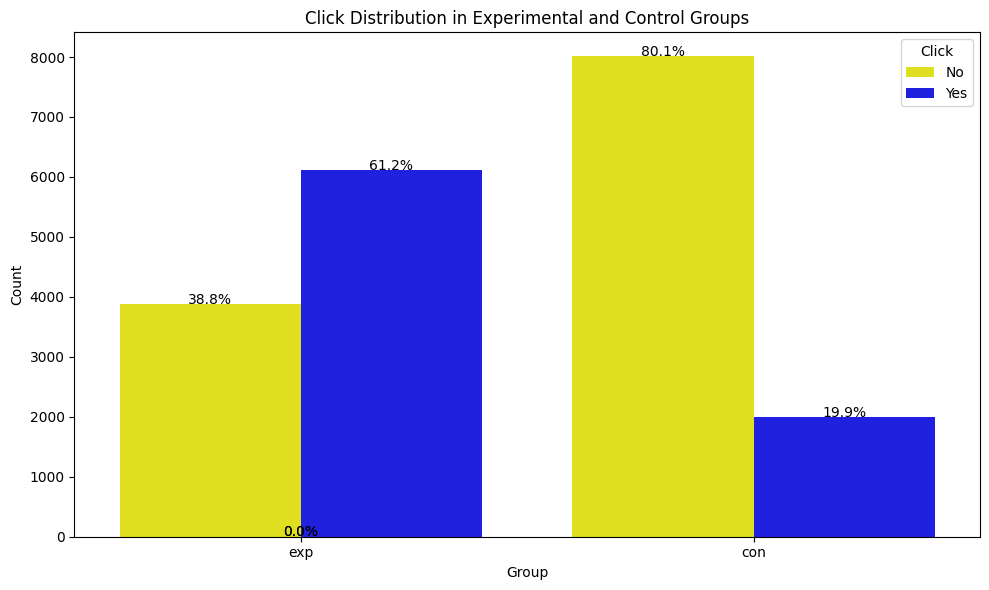

In [22]:
# Custom palette for yellow and black
palette = {0: 'yellow', 1: 'blue'}  # Assuming 0 is for no-click, 1 for click

# Plotting the click distribution for each group with the custom colors
plt.figure(figsize=(10, 6))
ax = sns.countplot(x='group', hue='click', data=df, palette=palette)
plt.title('Click Distribution in Experimental and Control Groups')
plt.xlabel('Group')
plt.ylabel('Count')
plt.legend(title='Click', labels=['No', 'Yes'])

# Calculate the percentages and annotate the bars
group_counts = df.groupby(['group']).size()
print(group_counts)
group_click_counts = df.groupby(['group', 'click']).size().reset_index(name='count')

for p in ax.patches:
    height = p.get_height()
    # Find the group and click type for the current bar
    group = 'exp' if p.get_x() < 0.5 else 'con'
    click = 1 if p.get_x() % 1 > 0.5 else 0
    total = group_counts.loc[group]
    percentage = 100 * height / total
    ax.text(p.get_x() + p.get_width() / 2., height + 5, f'{percentage:.1f}%', ha="center", color='black', fontsize=10)

plt.tight_layout()
plt.show()

# Power Analysis

**beta** -> probability of making a type II error (false negative)

**alpha** -> probability of making a type I error (false positive)

**1-beta** -> power of the test

**delta** -> minimum detectable effectt size

In [23]:
alpha = 0.05
print("Alpha: Significance Level is", alpha)

delta = 0.01
print("Delta: Minimum Detectable Effect Size is", delta)

Alpha: Significance Level is 0.05
Delta: Minimum Detectable Effect Size is 0.02


***Calculating the total number of clicks in the control and experiment groups***

In [39]:
#Number of clicks of control and experiment groups
X_con = df.groupby("group")['click'].sum().loc['con']
X_exp = df.groupby("group")['click'].sum().loc['exp']

#Number in control and experiment groups
N_con = df.groupby("group").click.count().loc['con']
N_exp = df.groupby("group").click.count().loc['exp']

print(f"Total users in control group : {N_con}")
print(f"Total users in experiment group : {N_exp}")

# print(df.groupby("group")['click'].sum())
print("Number of Clicks in Control Group:", X_con)
print("Number of Clicks in Experiment Group:", X_exp)

Total users in control group : 10000
Total users in experiment group : 10000
Number of Clicks in Control Group: 1989
Number of Clicks in Experiment Group: 6116


***Calculating Pooled Estimate for Clicks per Group***

In [40]:
#Probability of clicks per group
p_con_hat = X_con / N_con
p_exp_hat = X_exp / N_exp

print("Click probability in control group:", p_con_hat)
print("Click probability in experiment group:", p_exp_hat)

#Pooled Click Probability
p_pooled_hat = (X_con + X_exp) / (N_con + N_exp)
print("Pooled Click Probability:", p_pooled_hat)

Click probability in control group: 0.1989
Click probability in experiment group: 0.6116
Pooled Click Probability: 0.40525


***Calculating the Pooled Variance***

In [42]:
var_pooled = p_pooled_hat * (1 - p_pooled_hat) * (1 / N_con + 1 / N_exp)
print("Pooled Probability:", p_pooled_hat)
print("Pooled Variance:", var_pooled)

Pooled Probability: 0.40525
Pooled Variance: 4.82044875e-05


***Calculating the Standard Error and Test Statistics(of Z Test)***

In [44]:
SE = np.sqrt(var_pooled)
print("Standard Error:", SE)

#Compute Test Statistics of 2 sampled Z Test
Test_Statistic = (p_con_hat - p_exp_hat) / SE
print("Test Statistics of 2 sampled Z-test is:", Test_Statistic)

#Calculate the critical value of Z test
z_critical = stats.norm.ppf(1 - alpha / 2)
print("Critical Value of Z test(Standard Normal Distribution):", z_critical)

Standard Error: 0.006942945160376826
Test Statistics: -59.44163326469381
Critical Value of Z test(Standard Normal Distribution): 1.959963984540054


***Calculating the P-Value of Z-Test***

A low p value (< 0.05) indicates strong evidence that the null hypothesis should be rejected.

A high p value (> 0.05) indicates weak evidence against the null hypothesis so we fail to reject the null hypothesis.

# Statistical Significance Analysis

In [48]:
p_value = 2 * stats.norm.sf(np.abs(Test_Statistic))
print("P-Value of Z-Test is:", round(p_value,3)) # Two-tailed test

#Function to check the statistical significance of the test
def is_statistically_significant(p_value, alpha):
    if p_value < alpha:
        print("We have strong evidence to reject the null hypothesis\nThere is statistical significance, indicating that the observed differences between the groups are unlikely to have occurred by chance alone.\nThis suggests that the changes in the experimental group have a real effect compared to the control group.")
    else:
        print("We have weak evidence against the null hypothesis so we fail to reject the null hypothesis\nThere is no statistical significance, suggesting that the observed differences between the groups could have occurred by chance.\nThis implies that the changes in the experimental group do not have a substantial effect compared to the control group.")

is_statistically_significant(p_value, alpha)

P-Value of Z-Test is: 0.0
We have strong evidence to reject the null hypothesis
There is statistical significance, indicating that the observed differences between the groups are unlikely to have occurred by chance alone.
This suggests that the changes in the experimental group have a real effect compared to the control group.


#Visualization of the Z-Test Results

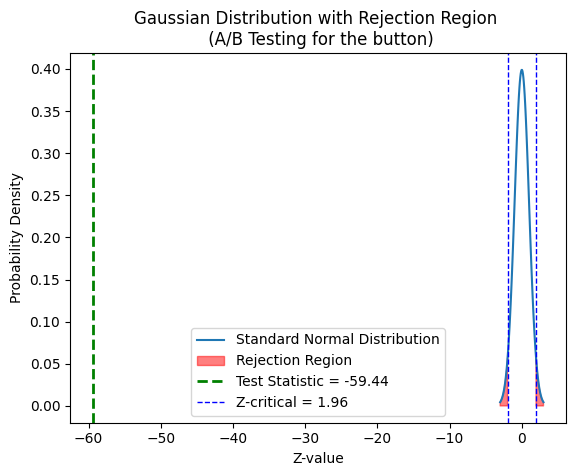

In [50]:
# Parameters for the standard normal distribution
mu = 0  # Mean
sigma = 1  # Standard deviation
x = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)
y = stats.norm.pdf(x, mu, sigma)


# Plotting the standard normal distribution
plt.plot(x, y, label='Standard Normal Distribution')
# Shade the rejection region for a two-tailed test
plt.fill_between(x, y, where=(x > z_critical) | (x < -z_critical), color='red', alpha=0.5, label='Rejection Region')
# Adding Test Statistic
plt.axvline(Test_Statistic, color='green', linestyle='dashed', linewidth=2, label=f'Test Statistic = {Test_Statistic:.2f}')
# Adding Z-critical values
plt.axvline(z_critical, color='blue', linestyle='dashed', linewidth=1, label=f'Z-critical = {z_critical:.2f}')
plt.axvline(-z_critical, color='blue', linestyle='dashed', linewidth=1)

# Adding labels and title
plt.xlabel('Z-value')
plt.ylabel('Probability Density')
plt.title('Gaussian Distribution with Rejection Region \n (A/B Testing for the button)')
plt.legend()
# Show plot
plt.show()

***Calculating the Confidence Interval of the Test***

In [51]:
MOE = z_critical * SE
CI = [
    round((p_exp_hat - p_con_hat) - MOE, 3),
    round((p_exp_hat - p_con_hat) + MOE, 3)
]

print("Confidence Interval of the 2-sampled Z Test is:", CI)

Confidence Interval of the 2-sampled Z Test is: [np.float64(0.399), np.float64(0.426)]


# Testing for Practical Significance in A/B Testing

In [58]:
def is_practically_significant(ci, delta):
    
    lower_bound = ci[0]
    
    if lower_bound <= delta:
        print("We have practical significance! \nWith MDE of {delta}, The difference between Control and Experimental group is practically significant")
    else:
        print("We do not have practical significance! \nWith MDE of {delta}, The difference between Control and Experimental group is not practically significant")
delta = 0.5
print("Minimum Detectable Effect Size:", delta)
print("Confidence Interval of the 2-sampled Z Test is:", CI)
is_practically_significant(CI, delta)

Minimum Detectable Effect Size: 0.5
Confidence Interval of the 2-sampled Z Test is: [np.float64(0.399), np.float64(0.426)]
We have practical significance! 
With MDE of {delta}, The difference between Control and Experimental group is practically significant
